This notebook determines the recovery rates of discharge events for bege, ppc and coax detector types.

**Contents:**

**Section 1:** Extracts all the discharge events. This process has previously been conducted in the notebook `CUTS_SELECTION_CRITERIA.ipynb`.

**Section 2:** This section calculates the recovery rates.


In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

## Section 1

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store()
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T004658Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "bege"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

In [6]:
tb_data_dict = {}  
wfs_all_dict = {} 

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]
    
    min_values = []

    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    
    min_z_scores = zscore(min_values)
    
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    for i, z_score in enumerate(min_z_scores):
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1 
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    for i, z_score in enumerate(max_z_scores):
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [14]:
threshold =1 #one standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

In [16]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1 
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            #plt.plot(ts[:], wf0[:], label=f'Event {i}')

        # Customize plot
        #plt.xlabel('Time ($\mu s$)')
        #plt.ylabel('Voltage (mV)')
        #plt.title(f'Skipped events in detector {j} which is a {test}')
        #plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        #print(f"Percentage of discharges present: {percentage}%")
        #plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Skipped waveforms for detector ch1107202: [450]
Skipped waveforms for detector ch1110402: [18, 771]
This detector ch1110403 doesn't have any discharges
This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [436, 634, 767, 891, 1297]
Skipped waveforms for detector ch1113601: [436, 634, 767, 1123, 1214, 1297]
Skipped waveforms for detector ch1113602: [853, 1061, 1123, 1214]
Skipped waveforms for detector ch1113603: [222, 853, 1061, 1116, 1310]
Skipped waveforms for detector ch1113604: [222, 326, 1116, 1310]
This detector ch1113605 doesn't have any discharges
Skipped waveforms for detector ch1120003: [20, 76, 492, 570, 751]
Skipped waveforms for detector ch1120004: [128, 317, 928, 948, 1325]
This detector ch1078405 doesn't have any discharges
Skipped waveforms for detector ch1080000: [584, 906, 1179, 1247]
Skipped waveforms for detector ch1080001: [171, 174, 1232]
This detector ch1080002 doesn't have any discharges
This detector ch1083200 doesn't ha

In [17]:
detector_events ={}
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    events = []
    detector_events[j]=events 
    for i in range(len(wfs_all)):
        wf0=wfs_all[i,:]
        if np.any(wf0[:]==0):
            events.append(i)

In [18]:
final_events = {}
for j in detectors_bege:
    all_zeros = detector_events[j]
    try:
        all_events = skipped_waveforms[j]
    except KeyError:
        all_events =[]
    
    combo=all_zeros+all_events
    final = np.unique(combo)
    final_events[j]=final 

In [19]:
import pandas as pd

df = pd.DataFrame(columns=['Detector Name', 'Percentage of discharge events'])

percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = final_events[j]

    if len(index_skip1) < 20: 
        skipped_waveforms[j] = index_skip1  
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:] #removes the ch from the detector name 
            test = cmap[x]['type'] #searches the type of detector the detector is 

            #plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            #plt.xlabel('Time ($\mu s$)')
            #plt.ylabel('Voltage (mV)')
            #plt.title(f'Skipped events in detector {j} which is a {test}')
            #plt.legend()
            #plt.show()

        diff = len(minimum_dict[j]) - len(index_skip1) 
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        #print(f"Percentage of discharges present: {percentage}%")
        #plt.show() 
    else:
        #if the dataset has more than 20 data points then the data set has no discharges
        percent_discharge[j] = 0
        #print(f"This detector {j} doesn't have any discharges")

Skipped waveforms for detector ch1107202: [450]
Skipped waveforms for detector ch1110402: [ 18 771]
Skipped waveforms for detector ch1110403: []
Skipped waveforms for detector ch1112005: []
Skipped waveforms for detector ch1113600: [ 436  634  767  891 1297]
Skipped waveforms for detector ch1113601: [ 436  634  767  891 1123 1214 1297]
Skipped waveforms for detector ch1113602: [ 853 1061 1123 1214]
Skipped waveforms for detector ch1113603: [ 222  853 1061 1116 1310]
Skipped waveforms for detector ch1113604: [ 222  326 1116 1310]
Skipped waveforms for detector ch1113605: []
Skipped waveforms for detector ch1120003: [  20   76  313  492  570  751 1306]
Skipped waveforms for detector ch1120004: [ 128  317  928  948 1325]
Skipped waveforms for detector ch1078405: []
Skipped waveforms for detector ch1080000: [ 584  906 1179 1247]
Skipped waveforms for detector ch1080001: [ 171  174 1232]
Skipped waveforms for detector ch1080002: []
Skipped waveforms for detector ch1083200: [1054]
Skipped wa

## Section 2

recovery rate 4996.8s
DISCHARGE
Maximum difference: 461.6, 4996.8
Next maximum difference: 5329.6, 5798.400000000001


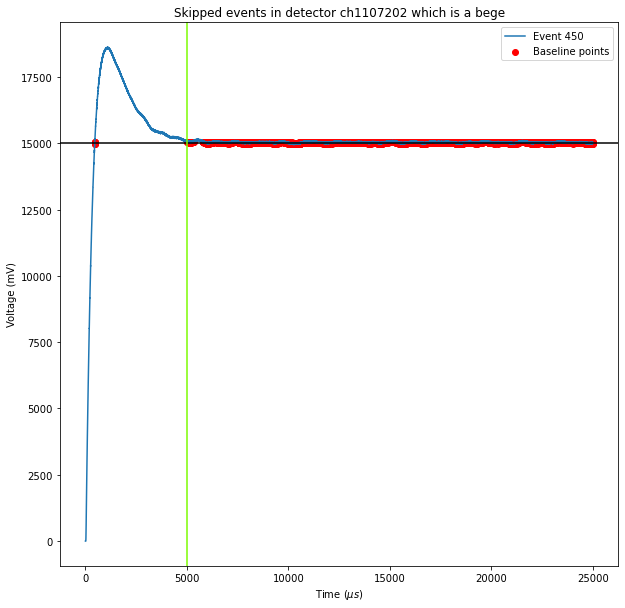

recovery rate 3420.8s
MICRODISCHARGE
Maximum difference: 4556.0, 7034.400000000001
Next Maximum difference: 3613.6000000000004, 4436.8


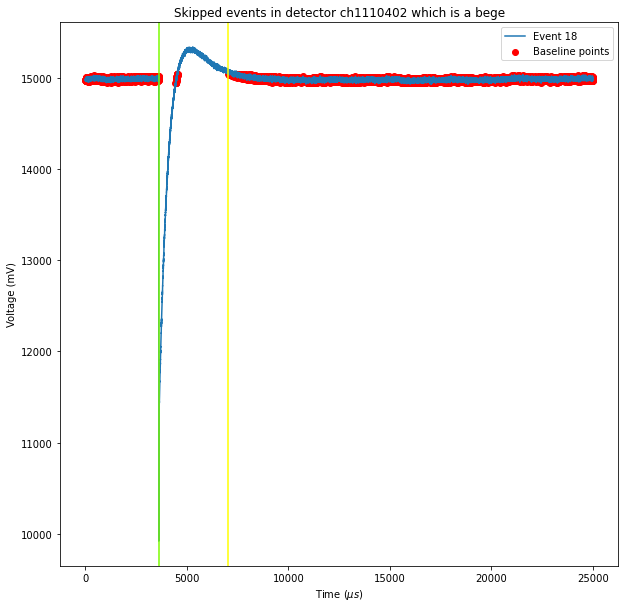

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 24956.0, 24957.600000000002
Next Maximum difference: 24957.600000000002, 24959.2


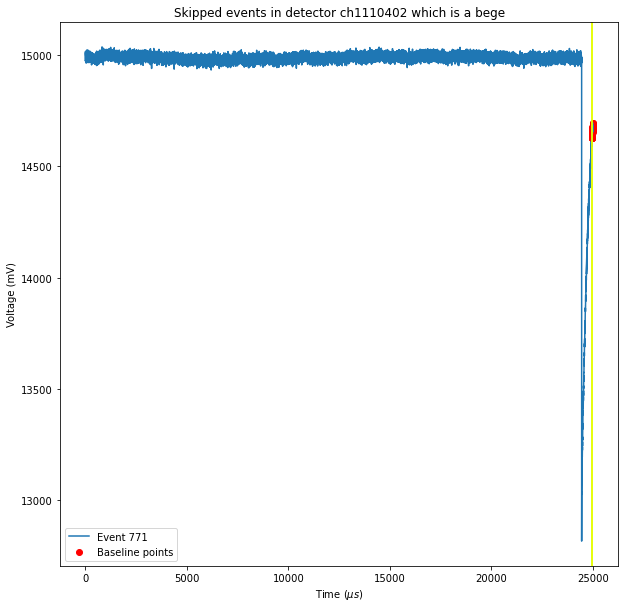

recovery rate 2923.2000000000003s
MICRODISCHARGE
Maximum difference: 480.8, 2923.2000000000003
Next Maximum difference: 2923.2000000000003, 2994.4


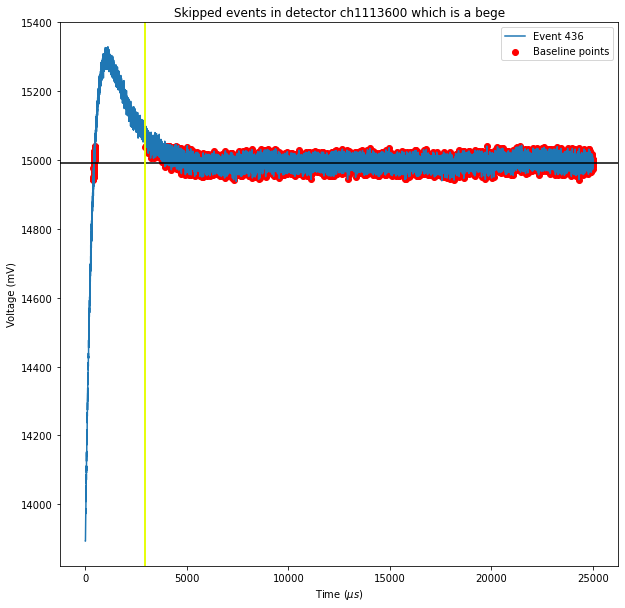

recovery rate 2642.4s
MICRODISCHARGE
Maximum difference: 419.20000000000005, 2642.4
Next Maximum difference: 2740.8, 2764.8


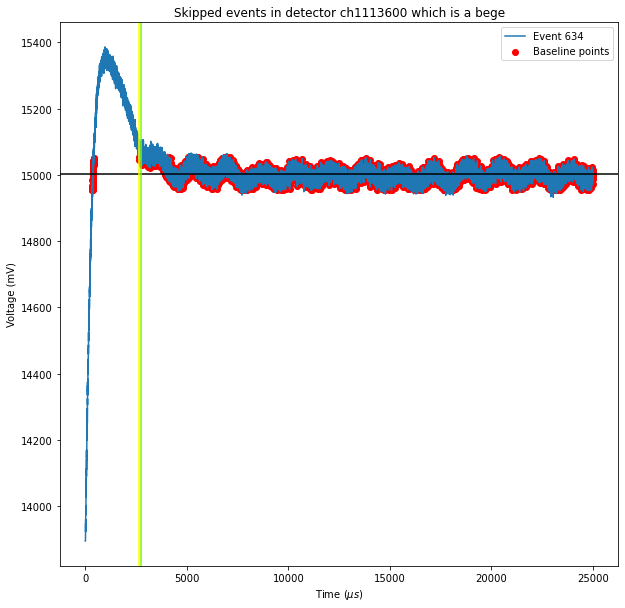

recovery rate 3439.2000000000003s
MICRODISCHARGE
Maximum difference: 215.20000000000002, 3439.2000000000003
Next Maximum difference: 3458.4, 3480.8


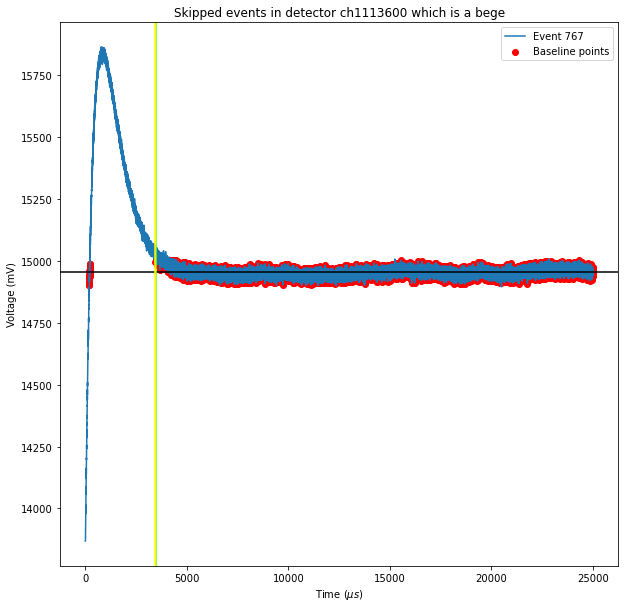

recovery rate 3022.4s
MICRODISCHARGE
Maximum difference: 338.40000000000003, 3022.4
Next Maximum difference: 3022.4, 3091.2000000000003


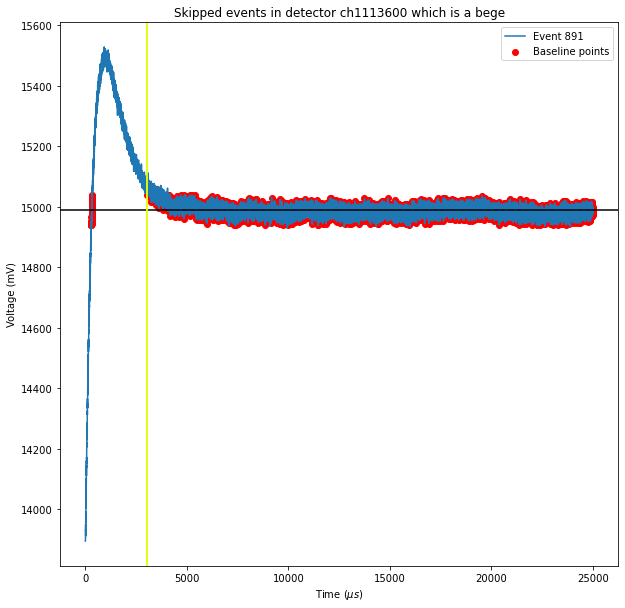

In [ ]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate'])


for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            
            mean_y = np.mean(wf0) # mean of the waveform
            
            #weighted mean calculation for the baseline 
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y)) #weights
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
                
                
                
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            
            for_append = []
            for_x = []
            for t, q in zip(ts, wf0):
                if weighted_average-51 < q < weighted_average+51:
                    for_x.append(t)
                    for_append.append(q)
                
            
            plt.scatter(for_x, for_append, color='r', label='Baseline points')
            #differences between points along the baseline
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:#if there is a gap in the baseline we have a discharge 
                #where does the maximum difference occur 
                max_diff_index = np.argmax(x_diff)
                
                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))
                #where does the next maximum difference occur
                next_max_index = np.argmax(masked_data)

                # indices above are used to determine the x point where the maximum occurs 
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]
                # indices above are used to determine the x point where the next maximum occurs 
                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
                
                #if at t=0 the waveform is below the baseline
                # the recovery rate is as follows 
                if (wf0[0]<weighted_average-51):
                    rec_rate = max_diff_x2
                    print(f"recovery rate {rec_rate}s")
                    plt.axhline(y=weighted_average,color='k')
                else: #otherwise the recovery rate is as follows
                    rec_rate = max_diff_x2-max_diff_x3
                    print(f"recovery rate {rec_rate}s")
                
                #if at any point the waveform = 0 it is a discharge event 
                if np.any(wf0[:]==0):
                    discharge_type = "discharge"
                    plt.axvline(x=rec_rate,color='lawngreen')
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)                    
                else: #if at any point ≠ 0 it is a microdischarge event
                    discharge_type = "microdischarge"
                    plt.axvline(x=max_diff_x3,color='lawngreen')
                    plt.axvline(x=max_diff_x2,color='yellow')
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df1 = df1.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)
            
            else:
                print("NO DISCHARGE")


            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [ ]:
#extracts the panda data files to an excel file 
excel_filename = 'discharge_bege1.xlsx'
df.to_excel(excel_filename, index=False)

excel_filename1 = 'microdischarge_bege1.xlsx'
df1.to_excel(excel_filename1, index=False)